# The Advanced Harmonic Oscillator

## Description

This exercise is about more advanced fitting of data. The idea is to begin with the simplest possible function that even remotely does the job, which is then expanded to accommodate all the features present in the data fitted. The data is from three versions of a damped harmonic oscillator, consisting of a weight hanging from a spring, but with different damping:
- No additional damping.
- More damping from a round piece of cardboard, which increases the drag.
- Damping from friction of the weight against metal.


## Your task

Take a look at the various dataset, and try to fit them with an appropriate function. By considering patterns in the fit residuals, one can get an idea of what to further include. Play around with the initial parameters of the fits and the various possible additions to the function. Answer / Discuss the questions written at the bottom of this notebook. Remember to try to fit all three datasets.

_Note that the initial fit values used here may not be the proper ones to begin with!!!_


##  Authors: 
- Troels Petersen ([email](mailto:petersen@nbi.dk))

## Date
11th of January 2022

In [1]:
import numpy as np                                     # Matlab like syntax for linear algebra and functions
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
import seaborn as sns                                  # Make the plots nicer to look at
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
import sys                                             # Modules to see files and folders in directories
from scipy import stats

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import warnings
warnings.filterwarnings("ignore")

In [2]:
sys.path.append('../../../External_Functions')
from ExternalFunctions import Chi2Regression, BinnedLH, UnbinnedLH
from ExternalFunctions import nice_string_output, add_text_to_ax    # Useful functions to print fit results on figure

In [3]:
# function to draw parameters from a fit on the figure in one line
def draw_fit_parameters(minuit_obj, axis, x, y, title=None, color='k', chi2=None, ndof=None, prob=None) :
    names = []
    values = []
    if title is not None :
        names += [title]
        values += ['']
    if chi2 is not None and ndof is not None and prob is not None :
        names += ['Chi2 / ndof','Prob']
        values += ["{:.3f} / {:d}".format(chi2, ndof), "{:.3f}".format(prob)]
    # names += minuit_obj.values.keys()
    names += minuit_obj.parameters
    values += ["{:.3f} +/- {:.3f}".format(minuit_obj.values[val], minuit_obj.errors[val]) for val in minuit_obj.parameters]
    d ={}
    for n,v in zip(names,values):
        d[n] = v
    axis.text(x, y, nice_string_output(d), family='monospace', transform=axis.transAxes, fontsize=10, verticalalignment='top', color=color)

In [4]:
SavePlots = False
verbose = True
Nverbose = 10

---
## 1st Dataset - no additional damping

  Time =  0.000    Dist = -0.683 
  Time =  0.010    Dist = -0.694 
  Time =  0.020    Dist = -0.702 
  Time =  0.030    Dist = -0.699 
  Time =  0.040    Dist = -0.702 
  Time =  0.050    Dist = -0.691 
  Time =  0.060    Dist = -0.684 
  Time =  0.070    Dist = -0.669 
  Time =  0.080    Dist = -0.644 
  Time =  0.090    Dist = -0.609 
  Number of entries read: 3806    Time of last read: 38.050


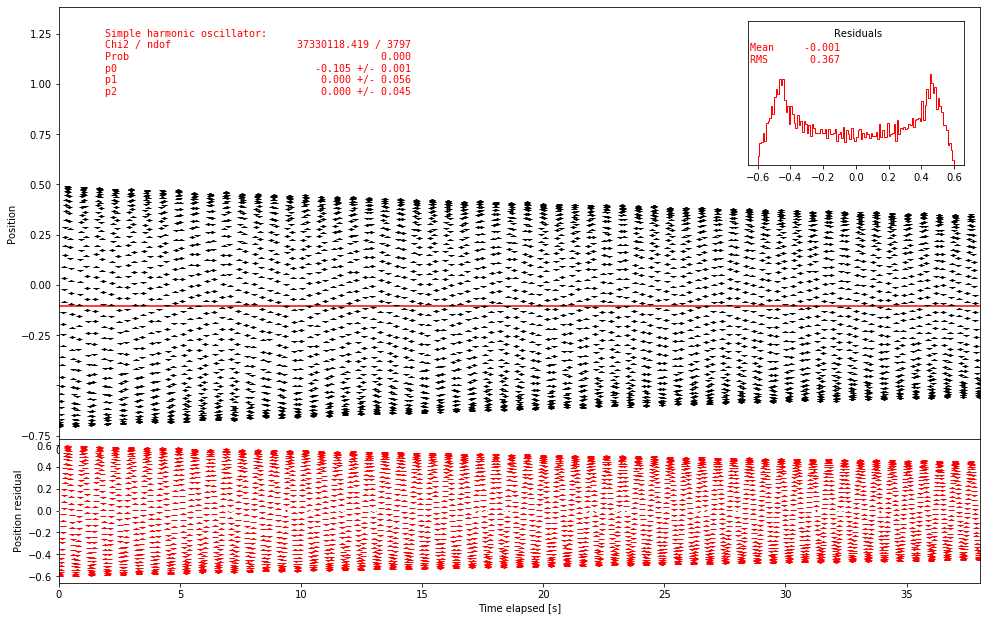

In [5]:
# Set variables:
# -------------------------------------- #
tmax = 38.0       # Maximum of time range fitted
filename = "data_HarmOsc1.txt"
    
# Load time and distance, assign uncertainty:
# -------------------------------------- #
time, dist = np.loadtxt(filename, unpack=True)
time -= time[0]                          # For ensuring that time starts at 0.0s!
edist = np.ones_like(dist)*0.0037        # I have estimated the uncertainty from a calibration with no swings.
    
# Check loaded data:
# -------------------------------------- #
if verbose :
    for i in range(Nverbose) :
        print("  Time = %6.3f    Dist = %6.3f "%(time[i], dist[i]))
print("  Number of entries read: %d    Time of last read: %6.3f"%(len(time), time[-1]))
    
# Sanity check (Did you check the data?):
for i in np.where((time < -0.001) | (time > 100.0) | (dist < -5.0) | (dist > 5.0))[0] :
    print("Warning: Strange value for time and/or dist!", i, time[i], dist[i])
    
# Plot the data:
# -------------------------------------- #
fig1 = plt.figure(figsize=(16, 10))   # Make an empty figure
ax1 = fig1.add_axes((.1,.3,.8,.6))    # Add the top subfigure
ax1.set_ylabel("Position")

ax1.errorbar(time, dist, edist, fmt='k_', label='data', ecolor='k', elinewidth=1, capsize=1, capthick=1)
ax1.set_xlim(time[0],time[-1])
ax1.set_ylim(top=ax1.get_ylim()[1]*2.5)


# Fit the data:
# -------------------------------------- #
mask = time < tmax
    
# Fit this data with a (initially too) simple harmonic function:
def fit1(x, p0, p1, p2) :
    return p0 * np.cos(p1*x+p2)
    
FitObject1 = Chi2Regression(fit1, time[mask], dist[mask], edist[mask])
Minuit1 = Minuit(FitObject1, p0=0.0, p1=0.0, p2=0.0)
Minuit1.errordef = 1.0
Minuit1.migrad()


chi2 = Minuit1.fval
ndof = len(time[mask])-len(Minuit1.values[:])
prob = stats.chi2.sf(chi2, ndof)

# Draw the function on top of the data:
x_fit = np.linspace(0, tmax, 1000)
y_fit = fit1(x_fit, *Minuit1.values[:])
ax1.plot(x_fit, y_fit, 'r-', label='Simple harmonic oscillator')
draw_fit_parameters(Minuit1, ax1, 0.05, 0.95, 'Simple harmonic oscillator:','r', chi2, ndof, prob)

# Calculate residuals:
# -------------------------------------- #
dd1 = dist-fit1(time, *Minuit1.values[:])
    
# Draw the residuals:
# -----------------------------------------
# Draw residuals as function of time in bottom subfigure
ax1.get_yaxis().get_ticklabels()[0].set_visible(False)
ax1.get_yaxis().get_ticklabels()[1].set_visible(False) # Remove bottom y-tick on top subfigure to prevent overlapping ticks
ax2 = fig1.add_axes((0.1,0.1,0.8,0.2),sharex=ax1)      # Add bottom subfigure for residuals, and have its x-axis follow the top figure
ax2.set_xlim(time[0], time[-1])
ax2.set_xlabel("Time elapsed [s]")
ax2.set_ylabel("Position residual")
    
ax2.errorbar(time, dd1, edist, fmt='r_', ecolor='r', elinewidth=1, capsize=1, capthick=1)
ax2.plot((0,tmax),(0,0), 'w--', lw=1, zorder=10)
    
# Draw histograms of residuals in a new inset figure
axins = inset_axes(ax1, 3.0, 2.0, loc=5, bbox_to_anchor=(0.89, 0.78), bbox_transform=ax1.figure.transFigure)
plt.yticks([],[])
axins.hist(dd1, bins=120, range=(-0.6, 0.6), histtype='step', linewidth=1, color='r')
axins.set_ylim(top=axins.get_ylim()[1]*1.5)
    
axins.text(0.40, 0.95, "Residuals", transform=axins.transAxes, fontsize=10, verticalalignment='top')
axins.text(0.01, 0.85, nice_string_output({'Mean': "{:.3f}".format(dd1.mean()),
                                           'RMS' : "{:.3f}".format(dd1.std(ddof=1))}),
            family='monospace', transform=axins.transAxes, fontsize=10, verticalalignment='top', color='r')

# Finalize the figure
if (SavePlots) :
    fig1.savefig("Fit_HarmOsc1.pdf", dpi=600)

Questions to 1st dataset:
------------------------

1. Look at the data file and plot and see if you can by eye (or simple fits) estimate
   the size of the uncertainty of the points. It is not easy, but you should be able
   to get it to within a factor of 2-3. Try for 5-10 minutes and discuss it with your
   neighbor before reading on!

           - - - - - -     5-10 minutes (success or failure) later - - - - - -

   If you didn't know how to estimate this uncertainty, then try to zoom in on a very
   small part of the curve (say xy: [0.1,0.3] x [-0.6,0.4]) in a large (e.g. 15x20) plot,
   where it should be possible to fit it with a line (even by eye).
   Since you know that for a small enough range of the data, this will be a reasonable
   PDF to use, you can extract the error from the RMS of the residuals, which gives you
   a rough estimate of the errors on the points (remember the pendulum timing!).
   Compare the error you got to the one I put in.


2. Once you have tried, set the error to 0.0037, and try to fit a damped harmonic oscillator.
   You should write the function yourself. Do so and run the fit before reading on.

           - - - - - -     5-10 minutes (success or failure) later - - - - - -

    Did you manage to write the fitting function? Also, did you remember to put in a
    parameter taking care of the offset from zero? Anyway, run the fit...

           - - - - - -     5-10 minutes (success or failure) later - - - - - -

3. Did the fit converge? I imagine that it didn't (thought it might have), and my first
   guess on why (apart from obvious bugs in the function) would be initial parameters. You
   need to set the initial parameters quite accurately, for the fit to work. Think about
   this, i.e. in a 5D parameter space, where being just 5% wrong or so will give you nothing
   of value?
   So now try to evaluate what some good initial values for the fit would be. You can
   start by simply making educated guesses, but if that fails, you can instead draw the
   function choosing some parameters, until it starts looking like the data you have.
   
          - - - - - -     10-20 minutes (success or failure) later - - - - - -
          
My guess is, that once you have a functioning harmonic oscillator fit running, then the fit will look reasonable. Never mind the ChiSquare value - it is hard to know the uncertainty anyway, and there may be a myriad of effects. 
The fit is not that bad, but clearly the residuals still have a lot of structure, which are thus features not included/accounted for in the fit. So you should try to add complexity to your fitting function.

The way to judge, if you are doing something right is to see if the ChiSquare (and the residuals) reduce every time you introduce something in addition. The ChiSquare should decrease every time, otherwise, the addition does not cover any corresponding effect in the data.

As inspiration to the more advanced fit, I could ask you:
 - Is there any visible damping? How to include that in the fit?
 - Are the period and/or phase constant?
 - Are there more than one exponential/oscillation in the system?

---

## 2nd Dataset

This dataset was acquired with the help of an overdamped oscillator (a cardboard panel was added to the weight, thereby increasing the atospheric drag of the system). This not only increases the damping, but also increases the complexity a bit.

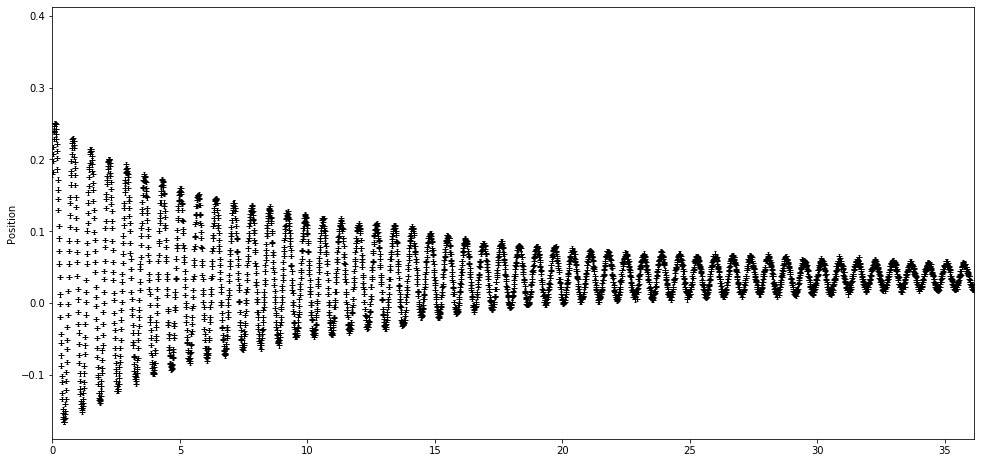

In [6]:
# Set variables:
# -------------------------------------- #
tmax = 36.0       # Maximum of time range fitted
filename = "data_HarmOsc2.txt"
    
# Load time and distance, assign uncertainty:
# -------------------------------------- #
time, dist = np.loadtxt(filename, unpack=True)
time -= time[0]      # For ensuring that time starts at 0.0s!
edist = np.ones_like(dist)*0.0029

# Plot the data:
# -------------------------------------- #
fig1 = plt.figure(figsize=(16, 10))   # Make an empty figure
ax1 = fig1.add_axes((.1,.3,.8,.6))    # Add the top subfigure
ax1.set_ylabel("Position")
    
# Make a graph of the data:
ax1.errorbar(time, dist, edist, fmt='k_', ecolor='k', elinewidth=1, capsize=1, capthick=1)
ax1.set_xlim(time[0],time[-1])
ax1.set_ylim(top=ax1.get_ylim()[1]*1.5);

Again, make a simple harmonic oscillator fit run. Now your job is to expand on the fitting function
and introduce terms to include various effects and thus reduce the Chi2. Set your fit to the range [0.005,36.005], and see how low a Chi2 you can get.

Also, can you see a change in the oscillation behaviour at some point? There seems to be a point at which something changes (damping goes from turbulent to regular?). Does your result improve, if you divide your fit into two parts around there? Three? Twenty?


----

## 3rd Dataset

This set corresponds to a set up in which the oscillator is __slowed__ by sliding constantly along a metal plate.

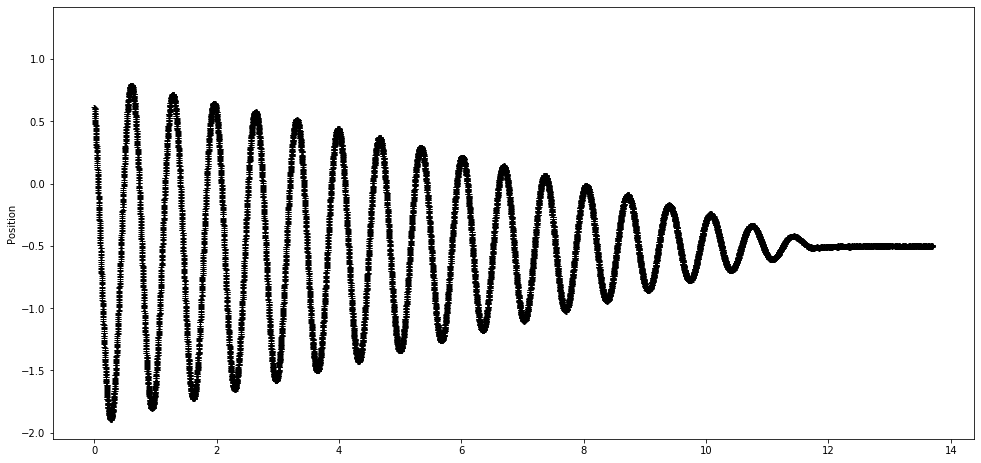

In [7]:
# Set variables:
# -------------------------------------- #
tmax = 12.0       # Maximum of time range fitted
filename = "data_HarmOsc3.txt"
    
# Load time and distance, assign uncertainty:
# -------------------------------------- #
time, dist = np.loadtxt(filename, unpack=True)
time -= time[0]      # For ensuring that time starts at 0.0s!
edist = np.ones_like(dist)*0.0139

# Plot the data:
# -------------------------------------- #
fig1 = plt.figure(figsize=(16, 10))   # Make an empty figure
ax1 = fig1.add_axes((.1,.3,.8,.6))    # Add the top subfigure
ax1.set_ylabel("Position")
    
# Make a graph of the data:
ax1.errorbar(time, dist, edist, fmt='k_', ecolor='k', elinewidth=1, capsize=1, capthick=1)
ax1.set_ylim(top=ax1.get_ylim()[1]*1.5);

The 3rd dataset exhibits a different type of damping in the oscillation. Fit this, and determine at which point in time the oscillation stops.

 ### You need to write this functional form of a damped harmonic oscillator:
 
 $d(t) = A \cdot\sin(\omega t+\phi) \cdot\exp(-\gamma t)$

In [8]:
#def fit1(x, p0, p1, p2, p3, p4) :
#     return p0 + p1*np.sin(p2*x+p3)*np.exp(-p4*x)

In [9]:
# Possible additions to especially the 2nd dataset could be:
#    def fit2(x,p0,p1,p2,p3,p4,p5,p6,p7) :           return p0 + p1 *  np.exp(-p2*x)                    * np.cos(p3+p4*x)         * (1.0 + p5*np.cos(p6*x+p7))
#    def fit3(x,p0,p1,p2,p3,p4,p5,p6,p7,p8) :        return p0 + p1 *  np.exp(-p2*x)                    * np.cos(p3+p4*x+p8*x**2) * (1.0 + p5*np.cos(p6*x+p7))
#    def fit4(x,p0,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10) : return p0 + p1 * (np.exp(-p2*x)+p9*np.exp(-p10*x)) * np.cos(p3+p4*x+p8*x**2) * (1.0 + p5*np.cos(p6*x+p7))